In [1]:
import pandas as pd #pandas to create small dataframes 
import numpy as np #Do aritmetic operations on arrays
import matplotlib # matplotlib: used to plot graphs
#matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots 
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train =pd.read_csv('/content/drive/MyDrive/demandPrediction/train_E1GspfA.csv')
test = pd.read_csv('/content/drive/MyDrive/demandPrediction/test_6QvDdzb.csv')
sample=pd.read_csv('/content/drive/MyDrive/demandPrediction/sample_4E0BhPN.csv')

In [4]:
test_f = pd.read_csv('/content/drive/MyDrive/demandPrediction/test_6QvDdzb.csv')
test_f1 = pd.read_csv('/content/drive/MyDrive/demandPrediction/test_6QvDdzb.csv')

In [5]:
train.describe()
train.dtypes

date      object
hour       int64
demand     int64
dtype: object

In [6]:
train.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [7]:
def datetime_func(df):
  df['hour_len']=df['hour'].astype(str).str.len()
  df['hour_str']=np.where((df['hour_len']==1),'0'+ df['hour'].astype(str)+'00',df['hour'].astype(str)+'00')
  df['DateTime'] = pd.to_datetime(df['date'] + ' ' + df['hour_str'].astype(str))
  return df

In [8]:
# creating datetime column for test and train data
train=datetime_func(train)
test=datetime_func(test)

In [9]:
train.head()

,date,hour,demand,hour_len,hour_str,DateTime
0,2018-08-18,9,91,1,0900,2018-08-18 09:00:00
1,2018-08-18,10,21,2,1000,2018-08-18 10:00:00
2,2018-08-18,13,23,2,1300,2018-08-18 13:00:00
3,2018-08-18,14,104,2,1400,2018-08-18 14:00:00
4,2018-08-18,15,81,2,1500,2018-08-18 15:00:00


In [10]:
test.head()

,date,hour,hour_len,hour_str,DateTime
0,2021-03-01,0,1,0000,2021-03-01 00:00:00
1,2021-03-01,1,1,0100,2021-03-01 01:00:00
2,2021-03-01,2,1,0200,2021-03-01 02:00:00
3,2021-03-01,3,1,0300,2021-03-01 03:00:00
4,2021-03-01,5,1,0500,2021-03-01 05:00:00


In [11]:
# creating features from datetime column
def datetime_fetures(df):
  df['month'] = df.DateTime.dt.month
  df['weekday'] = df.DateTime.dt.weekday
  df['year'] = df.DateTime.dt.year
  df['day'] = df.DateTime.dt.day
  df['day_of_year'] =pd.to_datetime(df['date']).dt.day_of_year
  df['days_in_month'] =pd.to_datetime(df['date']).dt.days_in_month
  df['is_leap_year'] =pd.to_datetime(df['date']).dt.is_leap_year

  # Adding if its day time hours or not feature
  df['IsDay']= df['hour'].apply(lambda x: 1 if x >=6 and x <=20 else 0)
  le=LabelEncoder()
  df['is_leap_year']=le.fit_transform(df['is_leap_year'])
  return df

In [12]:
train=datetime_fetures(train)
test=datetime_fetures(test)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


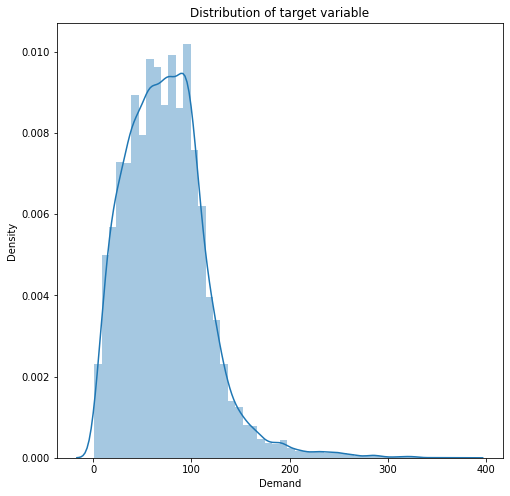

In [13]:
plt.figure(figsize=(8,8))
sns.distplot(train['demand'])
plt.xlabel("Demand")
plt.title("Distribution of target variable")
plt.show()

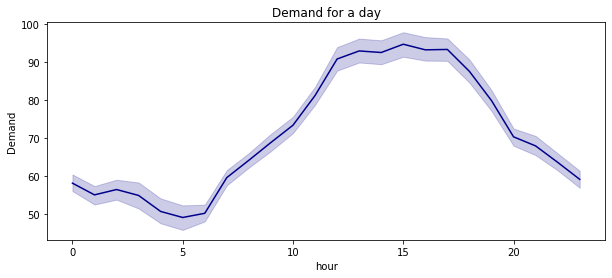

In [15]:
#Lets check the hour wise demand
plt.figure(figsize=(10,4))
hour= train.groupby(['DateTime','hour']).demand.mean().reset_index()
sns.lineplot(x=hour['hour'], y=hour['demand'], color='darkblue')
plt.ylabel("Demand")
plt.title("Demand for a day")
plt.show()

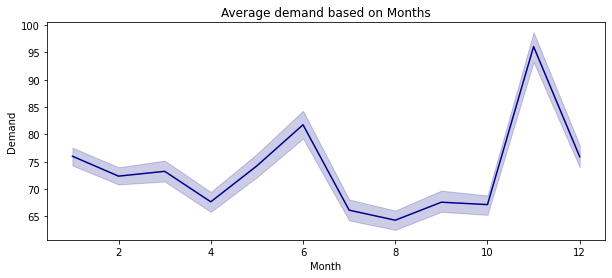

In [16]:
#Lets check the month wise demand
plt.figure(figsize=(10,4))
month_df= train.groupby(['DateTime','month']).demand.mean().reset_index()
sns.lineplot(x=month_df['month'], y=month_df['demand'], color='darkblue')

plt.xlabel("Month")
plt.ylabel("Demand")
plt.title("Average demand based on Months")
plt.show()

demand is high in holiday months



In [14]:
def feature_del(df):
  df.drop(['hour_len'], axis=1, inplace=True)
  df.drop(['hour_str'], axis=1, inplace=True)
  # df.drop(['DateTime'], axis=1, inplace=True)
  df.drop(['date'], axis=1, inplace=True)
  return df

In [15]:
train=feature_del(train)
test=feature_del(test)

In [19]:
train.head()

,hour,demand,DateTime,month,weekday,year,day,day_of_year,days_in_month,is_leap_year,IsDay
0,9,91,2018-08-18 09:00:00,8,5,2018,18,230,31,0,1
1,10,21,2018-08-18 10:00:00,8,5,2018,18,230,31,0,1
2,13,23,2018-08-18 13:00:00,8,5,2018,18,230,31,0,1
3,14,104,2018-08-18 14:00:00,8,5,2018,18,230,31,0,1
4,15,81,2018-08-18 15:00:00,8,5,2018,18,230,31,0,1


In [20]:
train.isna().sum()

hour             0
demand           0
DateTime         0
month            0
weekday          0
year             0
day              0
day_of_year      0
days_in_month    0
is_leap_year     0
IsDay            0
dtype: int64

In [21]:
test.head()

,hour,DateTime,month,weekday,year,day,day_of_year,days_in_month,is_leap_year,IsDay
0,0,2021-03-01 00:00:00,3,0,2021,1,60,31,0,0
1,1,2021-03-01 01:00:00,3,0,2021,1,60,31,0,0
2,2,2021-03-01 02:00:00,3,0,2021,1,60,31,0,0
3,3,2021-03-01 03:00:00,3,0,2021,1,60,31,0,0
4,5,2021-03-01 05:00:00,3,0,2021,1,60,31,0,0


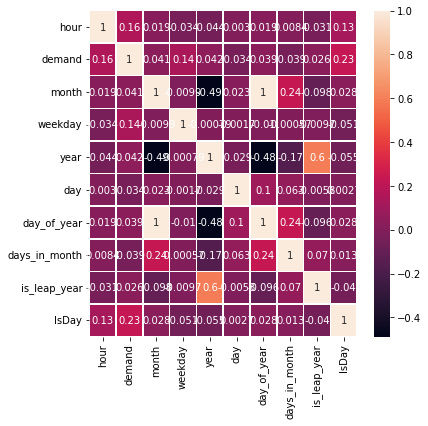

In [22]:
plt.figure(figsize=(6,6))
sns.heatmap(train.corr(), annot=True, linewidths=.5)
plt.show()

In [16]:
train=train.sort_values(by='DateTime')

In [17]:
X_train, X_cv= train_test_split(train, test_size=0.20, shuffle=False)

In [18]:
y_train = X_train['demand']
X_train = X_train.drop('demand', axis=1)
y_cv = X_cv['demand']
X_cv = X_cv.drop('demand', axis=1)

In [19]:
X_train.drop(['DateTime'], axis=1, inplace=True)
X_cv.drop(['DateTime'], axis=1, inplace=True)
test.drop(['DateTime'], axis=1, inplace=True)

In [20]:
X_train.head()

,hour,month,weekday,year,day,day_of_year,days_in_month,is_leap_year,IsDay
0,9,8,5,2018,18,230,31,0,1
1,10,8,5,2018,18,230,31,0,1
2,13,8,5,2018,18,230,31,0,1
3,14,8,5,2018,18,230,31,0,1
4,15,8,5,2018,18,230,31,0,1


In [21]:
y_train.dtypes

dtype('int64')

In [22]:
y_train= y_train.astype(float)
y_cv= y_cv.astype(float)

Linear Regression

In [30]:
linreg=LinearRegression()
linreg.fit(X_train,y_train)
train_pred=linreg.predict(X_train)
cv_pred=linreg.predict(X_cv)

train_rmse=mean_squared_error(y_train,train_pred)
cv_rmse=mean_squared_error(y_cv,cv_pred)

print("Linear Regression Training RMSE",np.sqrt(train_rmse))
print("Linear Regression Cross Vailidation RMSE",np.sqrt(cv_rmse))

Linear Regression Training RMSE 38.72934697971297
Linear Regression Cross Vailidation RMSE 41.99083447080178


Random Forest Regressor

In [31]:
from sklearn.metrics import r2_score,mean_squared_error
rf=RandomForestRegressor(random_state=44)
rf.fit(X_train,y_train)
rf_pred=rf.predict(X_train)
rf_pred1=rf.predict(X_cv)

print("RF Regression Training RMSE",r2_score(y_train,rf_pred))
print("RF Regression Cross Vailidation RMSE",r2_score(y_cv,rf_pred1))

RF Regression Training RMSE 0.9089223268669605
RF Regression Cross Vailidation RMSE 0.2412620579079634


In [33]:
rf_param_grid={'n_estimators':[100,150,200],'criterion':['mse'],'max_depth':[14,15,16],
    'min_samples_split':[3,4,5],'random_state':[96],'min_samples_leaf':[5,6,7]}

In [34]:
grid=GridSearchCV(estimator=rf, param_grid=rf_param_grid, n_jobs=-1, cv=4,verbose=1,
                  scoring='accuracy')

In [35]:
grid.fit(X_train,y_train)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=44), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [14, 15, 16],
                         'min_samples_leaf': [5, 6, 7],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [100, 150, 200],
                         'random_state': [96]},
             scoring='accuracy', verbose=1)

In [36]:
grid.best_params_

{'criterion': 'mse',
 'max_depth': 14,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 100,
 'random_state': 96}

In [38]:
grid_rf=RandomForestRegressor(criterion='mse',min_samples_leaf=5,max_depth=14, min_samples_split=3
                              ,n_estimators=100,random_state=96)
grid_rf.fit(X_train,y_train)
rf_pred=grid_rf.predict(X_train)
rf_pred1=grid_rf.predict(X_cv)

print("RF Regression Grid Training RMSE",np.sqrt(mean_squared_error(y_train,rf_pred)))
print("RF Regression Grid Cross Vailidation RMSE",np.sqrt(mean_squared_error(y_cv,rf_pred1)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RF Regression Grid Training RMSE 25.915723775703373
RF Regression Grid Cross Vailidation RMSE 37.764215624193426


MLP Regressor

In [28]:
from keras import Sequential
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout,BatchNormalization
from keras.initializers import glorot_uniform
from keras.optimizers import adam_v2
from keras.regularizers import l1
from tqdm import tqdm 
import tensorflow as tf

In [30]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [31]:
# Source: https://medium.com/analytics-vidhya/energy-prediction-of-buildings-ashrae-5d873cf038f1
inp_dim=X_train.shape[1]
earlystop= EarlyStopping(monitor='val_loss', mode='min', patience=3)

model=Sequential()
model.add(Dense(2048, activation='relu', input_shape=(inp_dim,)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
opt=adam_v2.Adam(0.0001)
model.compile(optimizer=opt, loss= root_mean_squared_error)
model.fit(X_train, y_train,epochs=50)

Epoch 1/50
457/457 [==============================] - 9s 19ms/step - loss: 44.2611
Epoch 2/50
457/457 [==============================] - 9s 19ms/step - loss: 40.1329
Epoch 3/50
457/457 [==============================] - 9s 19ms/step - loss: 39.9045
Epoch 4/50
457/457 [==============================] - 9s 19ms/step - loss: 39.8694
Epoch 5/50
457/457 [==============================] - 9s 19ms/step - loss: 39.6991
Epoch 6/50
457/457 [==============================] - 9s 19ms/step - loss: 39.4682
Epoch 7/50
457/457 [==============================] - 9s 19ms/step - loss: 39.3914
Epoch 8/50
457/457 [==============================] - 9s 19ms/step - loss: 39.1226
Epoch 9/50
457/457 [==============================] - 11s 23ms/step - loss: 39.0139
Epoch 10/50
457/457 [==============================] - 10s 22ms/step - loss: 38.9059
Epoch 11/50
457/457 [==============================] - 10s 22ms/step - loss: 38.8810
Epoch 12/50
457/457 [==============================] - 10s 22ms/step - loss: 38.79

In [ ]:
test_f.head()

,date,hour,demand
0,2021-03-01,0,46.734114
1,2021-03-01,1,46.293822
2,2021-03-01,2,65.249927
3,2021-03-01,3,35.952195
4,2021-03-01,5,65.492284


In [ ]:
# test_f.to_csv('/content/drive/MyDrive/demandPrediction/lgbmc5.csv', index=False)

In [ ]:
# # Adding cyclical time features on hour column
# X_train["hour_sin"] = X_train["hour"].apply(lambda x:np.sin(2*np.pi*x/24))
# X_train["hour_cos"] = X_train["hour"].apply(lambda x:np.cos(2*np.pi*x/24))

# test["hour_sin"] = test["hour"].apply(lambda x:np.sin(2*np.pi*x/24))
# # test["hour_cos"] = test["hour"].apply(lambda x:np.cos(2*np.pi*x/24))

LGBM Regressor RF

In [23]:
import math
from sklearn.metrics import mean_squared_error
lgb_reg=lgb.LGBMRegressor(boosting_type='rf', n_estimators=300, n_jobs=-1,objective='rmse',subsample=0.8,feature_fraction=0.8,bagging_freq=1)
lgb_reg.fit(X_train,y_train)
pred_reg_lgb_tr=lgb_reg.predict(X_train)
pred_reg_lgb_cv=lgb_reg.predict(X_cv)

print("Train rmse for estimators:", 300,'is',math.sqrt(mean_squared_error(y_train, pred_reg_lgb_tr)))
print("Cross Validation rmse for estimators:", 300,'is',math.sqrt(mean_squared_error(y_cv, pred_reg_lgb_cv)))

Train rmse for estimators: 300 is 33.04484877510405
Cross Validation rmse for estimators: 300 is 38.36293824819468


In [ ]:
# test_f1['demand']=lgb_reg.predict(test)

In [ ]:
# test_f1.head()

In [ ]:
# test_f1.to_csv('/content/drive/MyDrive/demandPrediction/lgbmc3.csv', index=False)

LGBM Regressor GBDT

In [24]:
import math
from sklearn.metrics import mean_squared_error
lgb_reg=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=2000, objective='rmse',n_jobs=-1)
lgb_reg.fit(X_train,y_train)
pred_reg_lgb_tr=lgb_reg.predict(X_train)
print("Train rmse for estimators:", 2000,'is',math.sqrt(mean_squared_error(y_train, pred_reg_lgb_tr)))
pred_reg_lgb_cv=lgb_reg.predict(X_cv)
print("Cross Validation rmse for estimators:", 2000,'is',math.sqrt(mean_squared_error(y_cv, pred_reg_lgb_cv)))

Train rmse for estimators: 2000 is 20.55050266892386
Cross Validation rmse for estimators: 2000 is 39.99624737289689


SVR

In [26]:
from sklearn.svm import SVR
sv=SVR(C=9.0, degree=9,gamma='scale',kernel='rbf')
sv.fit(X_train,y_train)
pred_sv_tr=sv.predict(X_train)
pred_sv_cv=sv.predict(X_cv)
print("Train rmse for SVR",math.sqrt(mean_squared_error(y_train, pred_sv_tr)))
print("Cross Validation rmse for SVR",math.sqrt(mean_squared_error(y_cv, pred_sv_cv)))

Train rmse for SVR 40.68395729025971
Cross Validation rmse for SVR 45.8465220489449


Decision Tree Regressor

In [27]:
dtr=DecisionTreeRegressor(max_depth=15,random_state=5)
dtr.fit(X_train, y_train)
dtr_pred_tr=dtr.predict(X_train)
dtr_pred_cv=dtr.predict(X_cv)
print("Train rmse for DTR is",math.sqrt(mean_squared_error(y_train, dtr_pred_tr)))
print("Cross Validation rmse for DTR is",math.sqrt(mean_squared_error(y_cv, dtr_pred_cv)))

Train rmse for DTR is 19.029422004491824
Cross Validation rmse for DTR is 46.48394691337646


Results Summary

In [32]:
from prettytable import PrettyTable
summary = PrettyTable()


summary.field_names = ["Model", "Train RMSE", "CV RMSE"]
summary.add_row(["Linear Regression",38.72934697971297 ,41.99083447080178])
summary.add_row(["RF Regressior",25.915723775703373 ,37.764215624193426])
summary.add_row(["LightGBM GBDT", 20.55050266892386,39.99624737289689])
summary.add_row(["LightGBM RF", 33.04484877510405,38.36293824819468])
summary.add_row(["SVR", 40.68395729025971,45.8465220489449])
summary.add_row(["MLP", 36.8876,"Not Calculated"])
summary.add_row(["Decision Trees", 19.029422004491824,46.48394691337646])
print(summary)

+-------------------+--------------------+--------------------+
|       Model       |     Train RMSE     |      CV RMSE       |
+-------------------+--------------------+--------------------+
| Linear Regression | 38.72934697971297  | 41.99083447080178  |
|   RF Regressior   | 25.915723775703373 | 37.764215624193426 |
|   LightGBM GBDT   | 20.55050266892386  | 39.99624737289689  |
|    LightGBM RF    | 33.04484877510405  | 38.36293824819468  |
|        SVR        | 40.68395729025971  |  45.8465220489449  |
|        MLP        |      36.8876       |   Not Calculated   |
|   Decision Trees  | 19.029422004491824 | 46.48394691337646  |
+-------------------+--------------------+--------------------+
